In [1]:
!conda install -y --freeze-installed pandas matplotlib scipy
!conda install -y -c conda-forge geopandas

Solving environment: done

## Package Plan ##

  environment location: /home/seagetch/anaconda3/envs/covid19

  added / updated specs:
    - matplotlib
    - pandas
    - scipy


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> pkgs/main::ca-certificates-2021.4.13-h06a4308_1

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2020.12.5-py39hf~ --> pkgs/main::certifi-2020.12.5-py39h06a4308_0
  openssl            conda-forge::openssl-1.1.1k-h7f98852_0 --> pkgs/main::openssl-1.1.1k-h27cfd23_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /home/seagetch/anaconda3/envs/covid19

  added / updated specs:
    - geopandas


The following packages will be UPDATED:

  certifi            pkgs/main::certifi-2020.12.5-py39h06a~ --> conda-forge::certifi-2020.12.5-py39hf3d15

In [2]:
!mkdir -p data
!cd data && git clone https://github.com/dataofjapan/land.git

fatal: destination path 'land' already exists and is not an empty directory.


In [3]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
import geopandas as gpd
#import japanmap
%matplotlib inline
font = {'family' : 'Noto Sans CJK JP'}
matplotlib.rc('font', **font)

In [4]:
!wget https://opendata.corona.go.jp/api/Covid19JapanAll -O data/Covid19JapanAll.json

--2021-05-26 11:32:58--  https://opendata.corona.go.jp/api/Covid19JapanAll
opendata.corona.go.jp (opendata.corona.go.jp) をDNSに問いあわせています... 138.91.0.30
opendata.corona.go.jp (opendata.corona.go.jp)|138.91.0.30|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 1166250 (1.1M) [application/json]
`data/Covid19JapanAll.json' に保存中

data/Covid19JapanAl 100%[===================>]   1.11M  2.31MB/s    in 0.5s    

2021-05-26 11:33:00 (2.31 MB/s) - `data/Covid19JapanAll.json' へ保存完了 [1166250/1166250]



In [5]:
!wget "https://www.e-stat.go.jp/stat-search/file-download?&statInfId=000031981656&fileKind=1" -O data/jp-population-stats.csv
!iconv -f Shift_JIS -t UTF-8 < data/jp-population-stats.csv > data/jp-population-stats-utf8.csv
!rm data/jp-population-stats.csv
with open("data/jp-population-stats-utf8.csv","r") as fr:
    with open("data/jp-population-stats.csv","w") as fw:
        lines = fr.read().split("\n")
        fw.write("\n".join(lines[14:]))
!rm data/jp-population-stats-utf8.csv

--2021-05-26 11:33:00--  https://www.e-stat.go.jp/stat-search/file-download?&statInfId=000031981656&fileKind=1
www.e-stat.go.jp (www.e-stat.go.jp) をDNSに問いあわせています... 2001:268:83a:ff::9, 111.108.189.107
www.e-stat.go.jp (www.e-stat.go.jp)|2001:268:83a:ff::9|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 10033 (9.8K) [text/csv]
`data/jp-population-stats.csv' に保存中

data/jp-population- 100%[===================>]   9.80K  --.-KB/s    in 0s      

2021-05-26 11:33:01 (78.8 MB/s) - `data/jp-population-stats.csv' へ保存完了 [10033/10033]



In [6]:
pref_populations = pd.read_csv("data/jp-population-stats.csv")
pref_populations.rename(columns={pref_populations.columns[0]: "prefecture"}, inplace=True)
pref_populations.drop(0, axis=0, inplace=True)
pref_populations["prefecture"] = pref_populations["prefecture"].str.replace("^...","", regex=True)
latest_populations = pref_populations[[pref_populations.columns[0], pref_populations.columns[-1]]]
latest_populations.set_index("prefecture", inplace=True)
latest_populations

2019
prefecture          
北海道          5211000
青森県          1240000
岩手県          1219000
宮城県          2283000
秋田県           963000
山形県          1070000
福島県          1831000
茨城県          2810000
栃木県          1906000
群馬県          1886000
埼玉県          7174000
千葉県          6141000
東京都         13405000
神奈川県         8997000
新潟県          2206000
富山県          1026000
石川県          1123000
福井県           756000
山梨県           798000
長野県          2016000
岐阜県          1940000
静岡県          3557000
愛知県          7316000
三重県          1736000
滋賀県          1385000
京都府          2527000
大阪府          8623000
兵庫県          5369000
奈良県          1319000
和歌山県          918000
鳥取県           551000
島根県           665000
岡山県          1866000
広島県          2761000
山口県          1340000
徳島県           723000
香川県           945000
愛媛県          1328000
高知県           693000
福岡県          5039000
佐賀県           808000
長崎県          1318000
熊本県          1731000
大分県          1123000
宮崎県          1065000
鹿児島県         1589000
沖縄県          1434000

In [7]:
with open("data/Covid19JapanAll.json","r") as f:
    raw = json.load(f)
    df = pd.DataFrame.from_dict(raw.get("itemList"))
df["date"] = pd.to_datetime(df["date"])
df["npatients"] = df["npatients"].astype(float)
df = df.iloc[::-1]
df

date name_jp  npatients
18658 2020-04-22     沖縄県      130.0
18657 2020-04-22    鹿児島県       10.0
18656 2020-04-22     宮崎県       17.0
18655 2020-04-22     大分県       60.0
18654 2020-04-22     熊本県       41.0
...          ...     ...        ...
4     2021-05-23     秋田県      741.0
3     2021-05-23     宮城県     8729.0
2     2021-05-23     岩手県     1343.0
1     2021-05-23     青森県     2158.0
0     2021-05-23     北海道    34581.0

[18659 rows x 3 columns]

In [8]:
def get_median_filtered(signal, threshold=3):
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

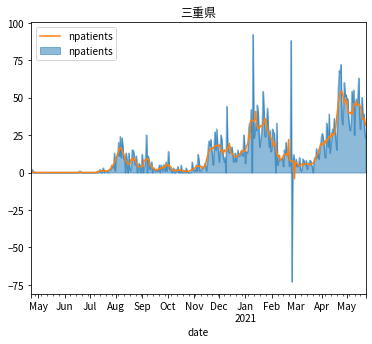

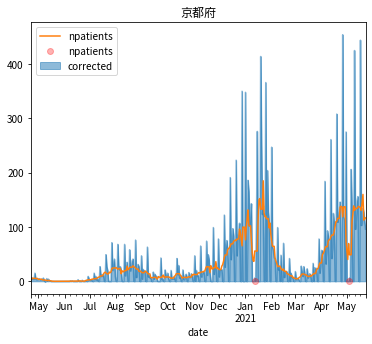

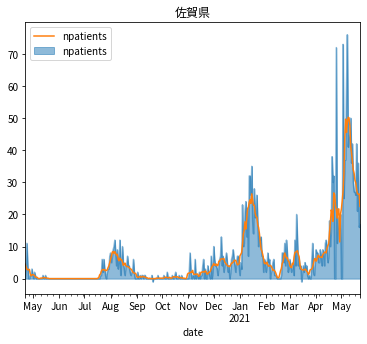

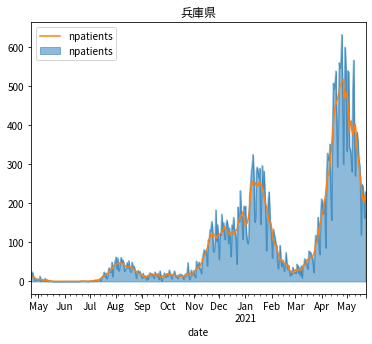

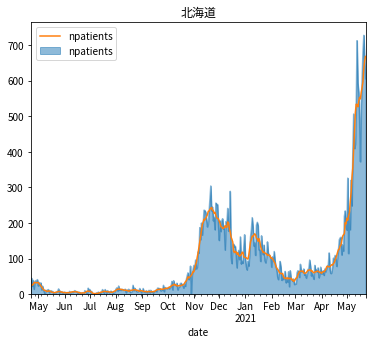

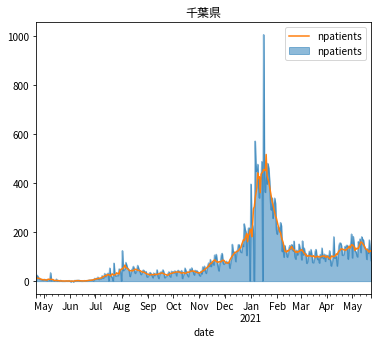

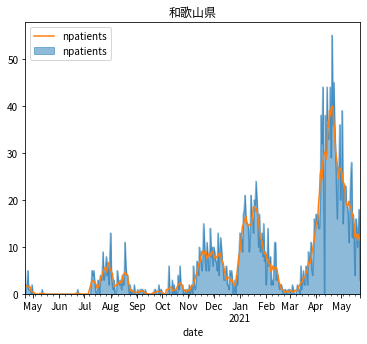

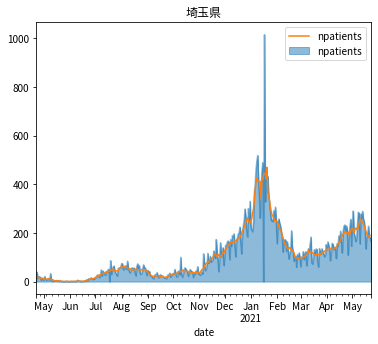

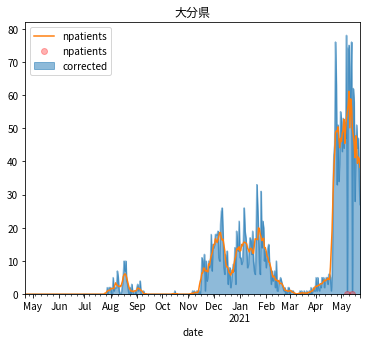

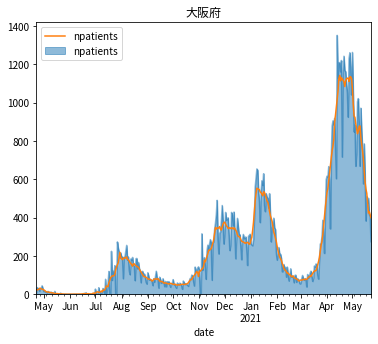

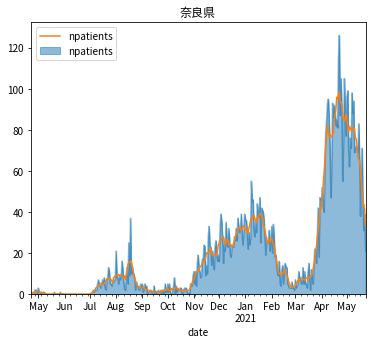

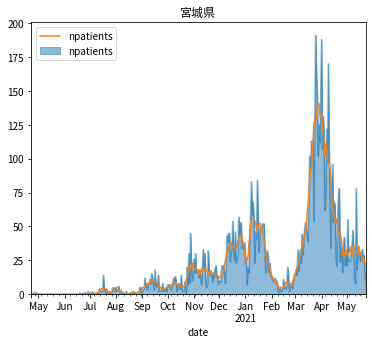

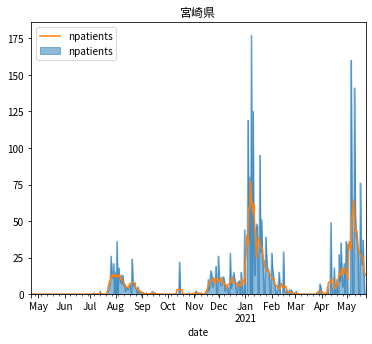

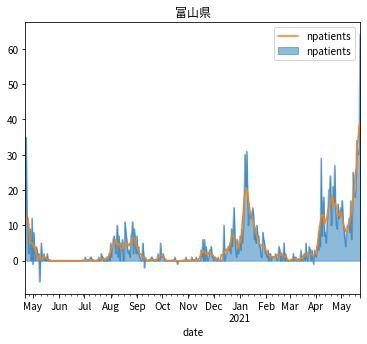

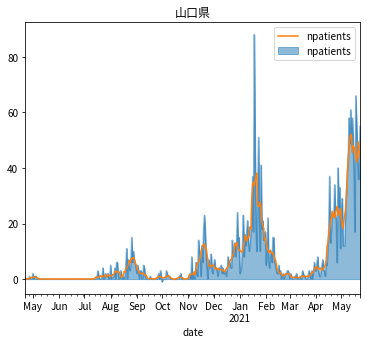

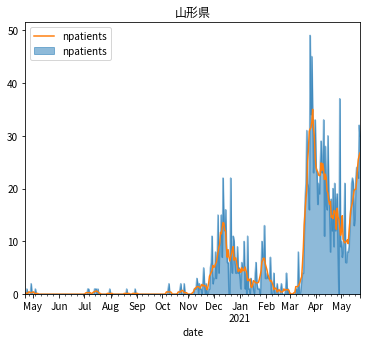

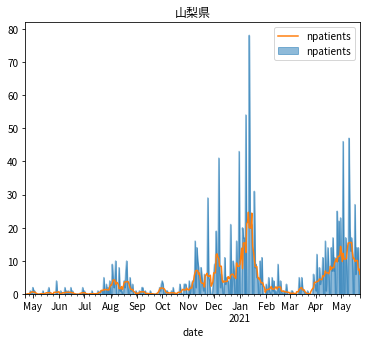

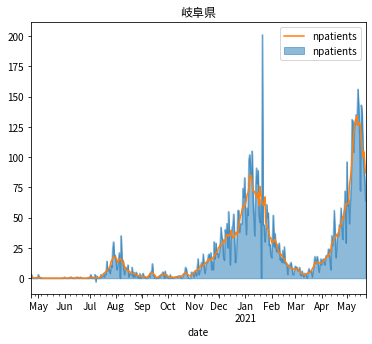

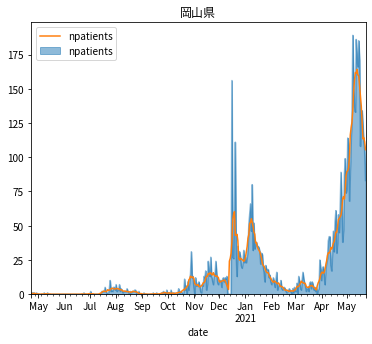

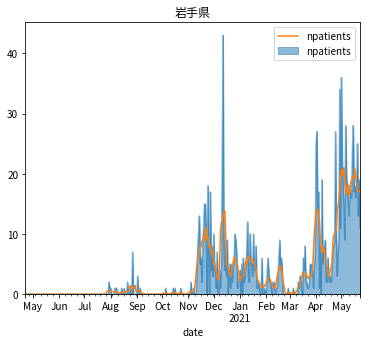

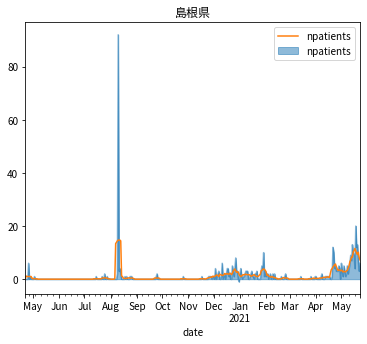

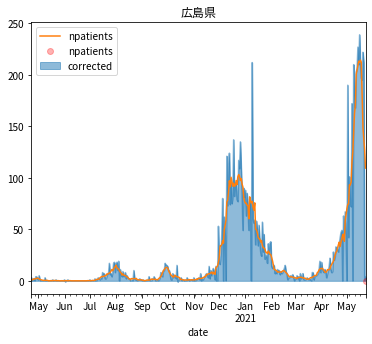

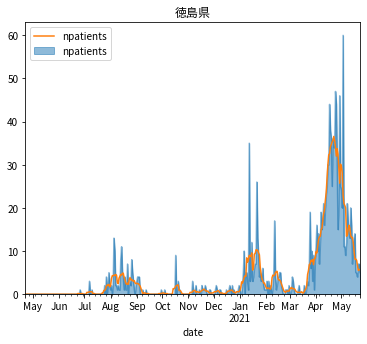

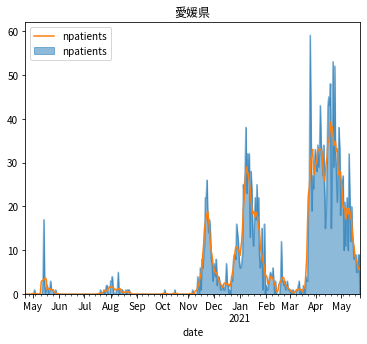

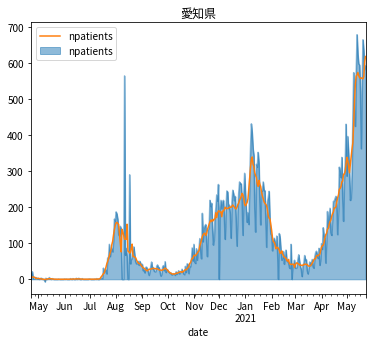

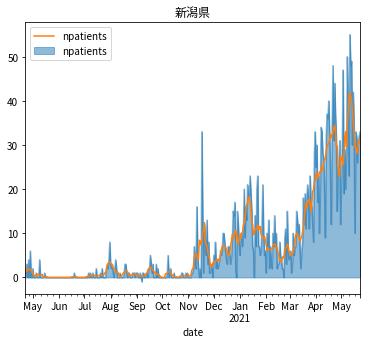

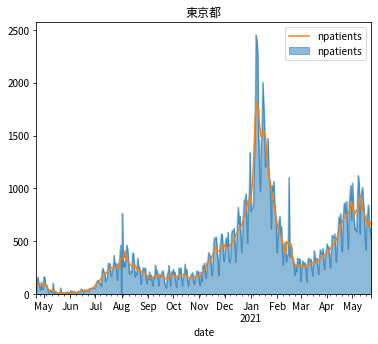

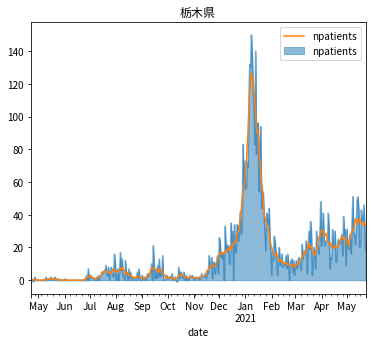

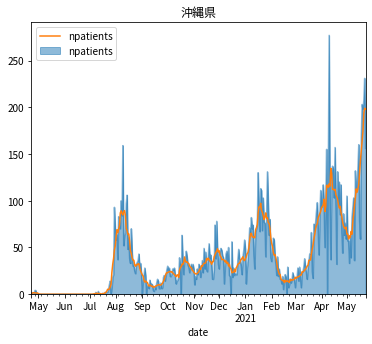

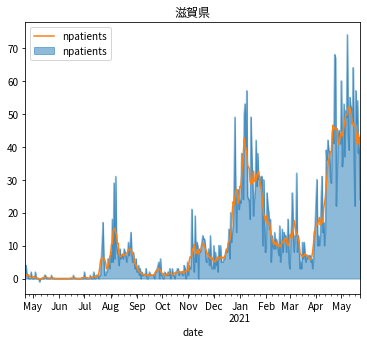

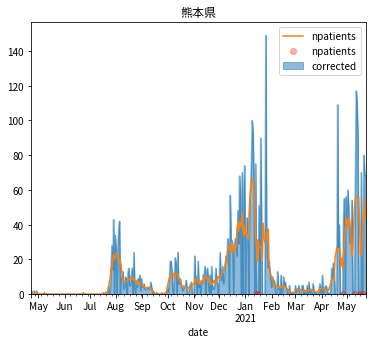

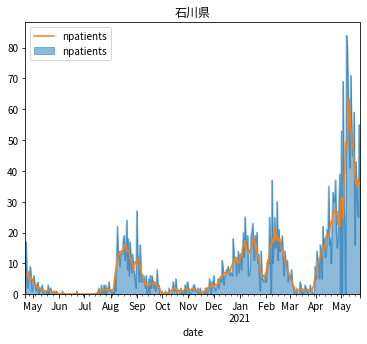

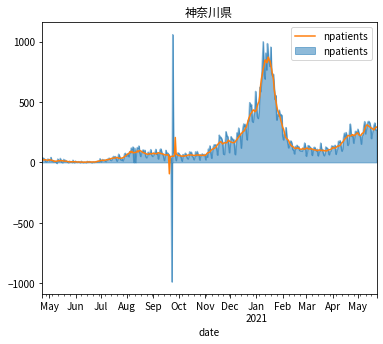

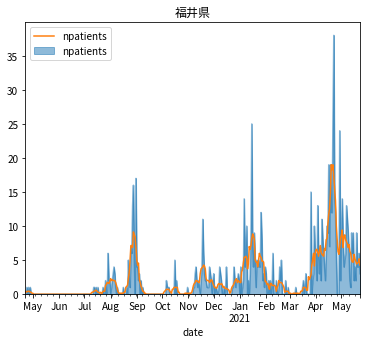

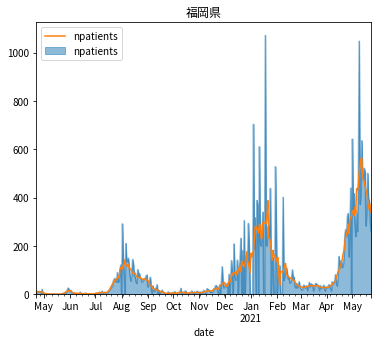

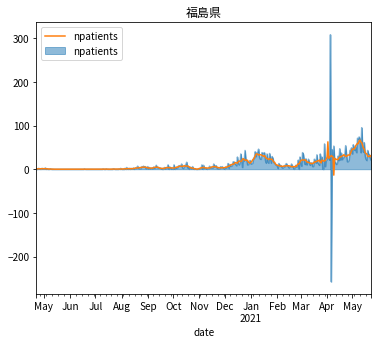

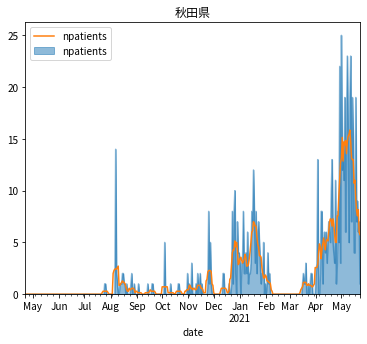

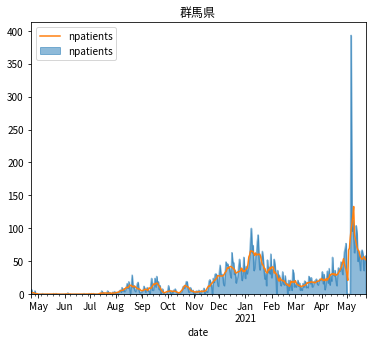

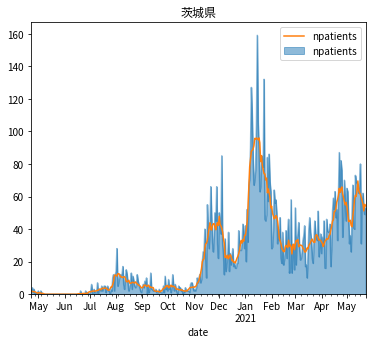

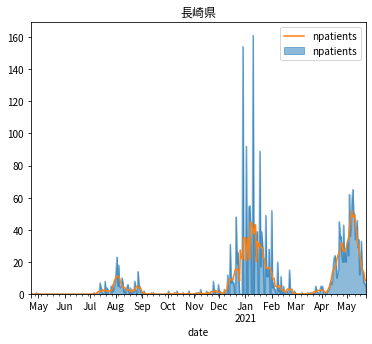

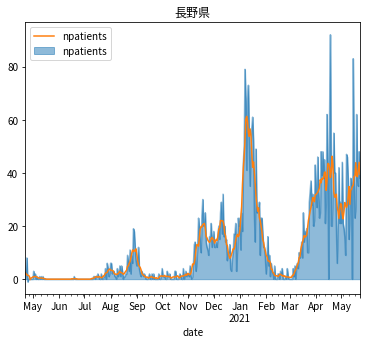

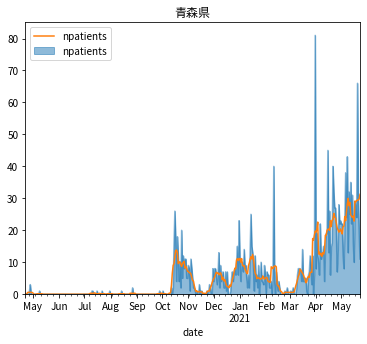

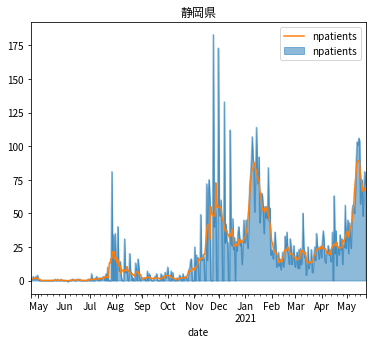

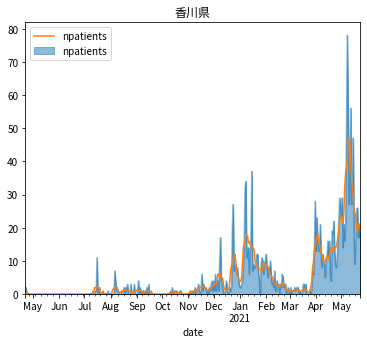

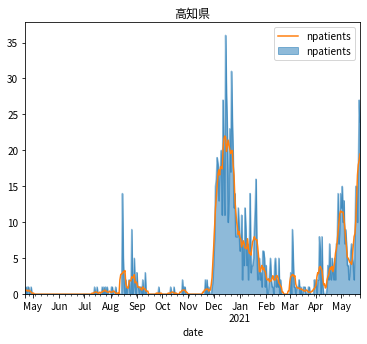

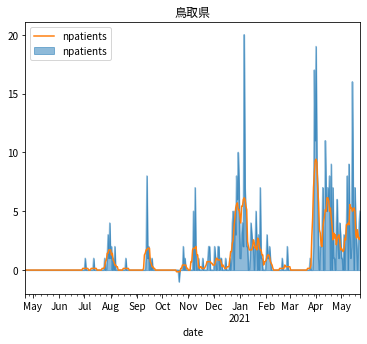

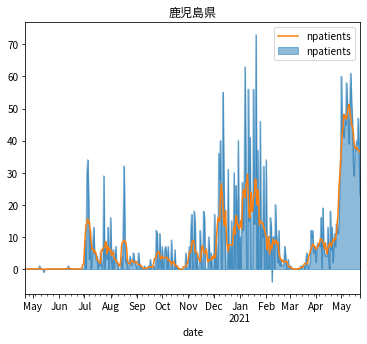

In [9]:
!mkdir -p japan_trends/prefectures
filtered = {}
for pref, subdf in df.groupby("name_jp"):
    subdf = subdf.drop("name_jp", axis=1)
    subdf["npatients"] = subdf["npatients"].diff().fillna(0)
    u_medf = subdf["u_medf"] = get_median_filtered(subdf['npatients'].values, threshold=80)
    outliers = subdf.loc[subdf["u_medf"].values != subdf['npatients'].values].copy()
    outliers["npatients"] = 0
    subdf.loc[subdf["u_medf"].values != subdf['npatients'].values, "npatients"] = np.median(subdf['npatients'].values)
    plotdf = subdf.drop("u_medf",axis=1).set_index("date")
    filtered[pref] = plotdf
    fig, ax = plt.subplots(figsize=(6, 5))
    plotdf.plot(ax=ax, title=pref,kind="area",stacked=False)
    plotdf.rolling(7, center=True, min_periods=1).mean().plot(ax=ax, kind="line")
    if outliers.shape[0]>0:
        outliers.rename(columns={"npatients": "corrected"}).drop("u_medf",axis=1).set_index("date").plot(ax=ax, marker='o', linestyle='none', color='r', alpha=0.3)
    display(fig)
    plt.savefig("japan_trends/prefectures/%s.png"%pref, facecolor="white")
    plt.close(fig)

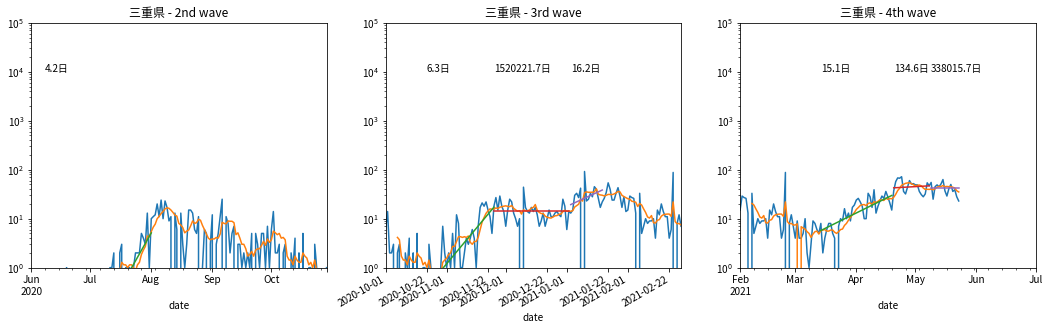

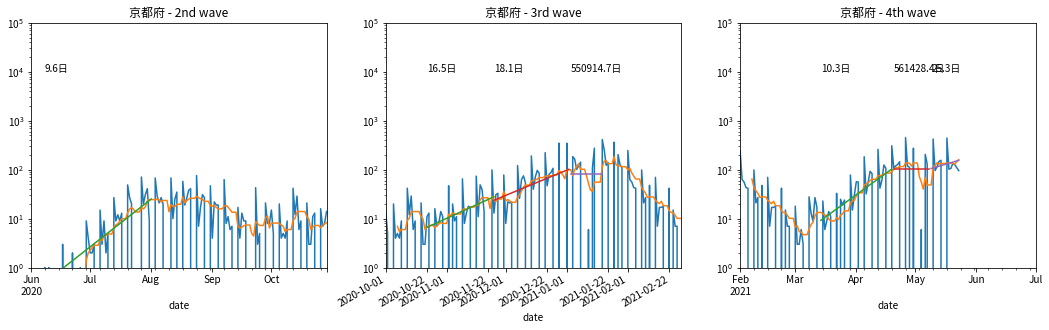

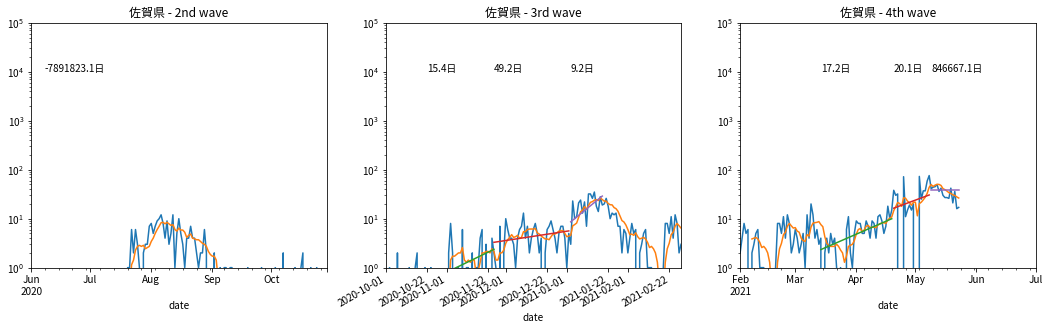

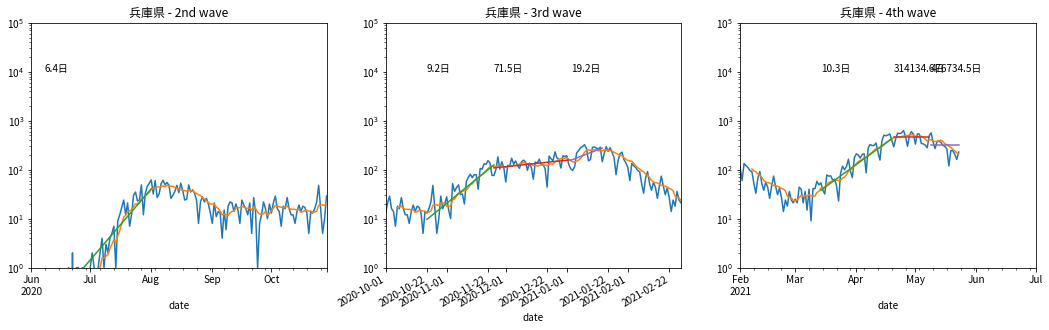

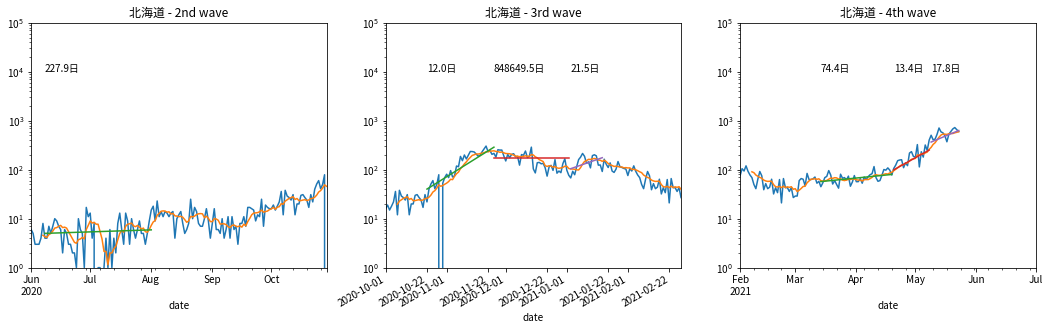

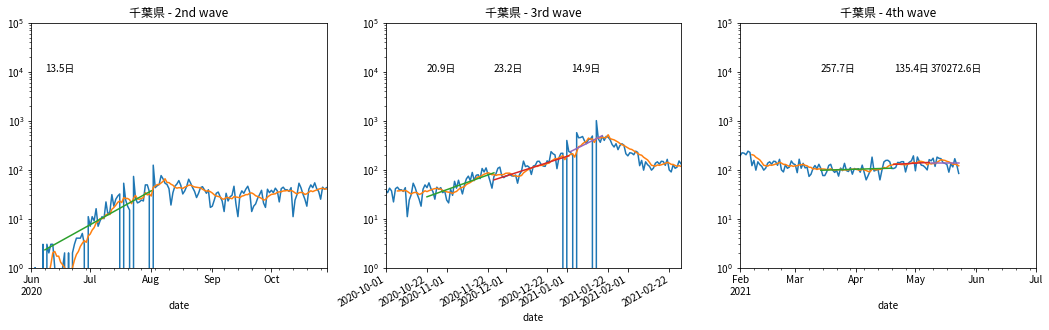

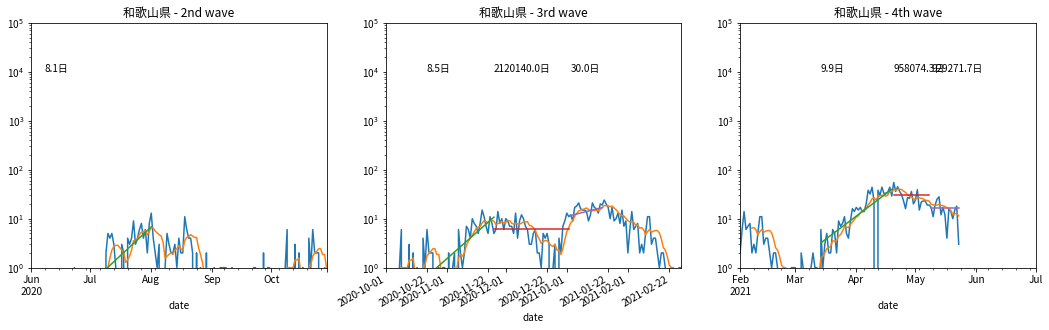

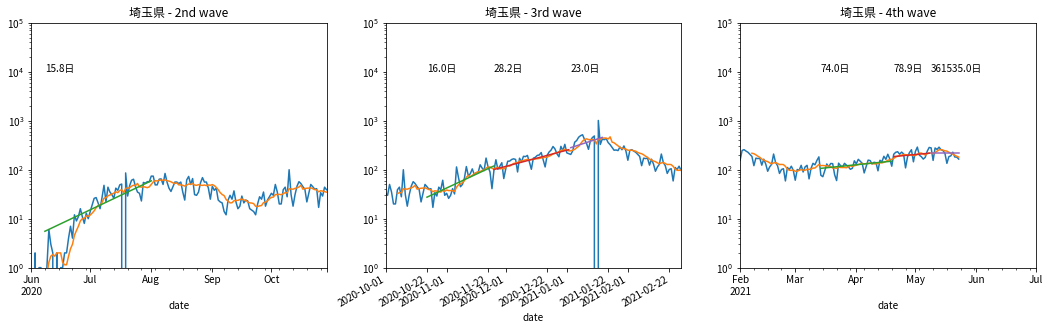

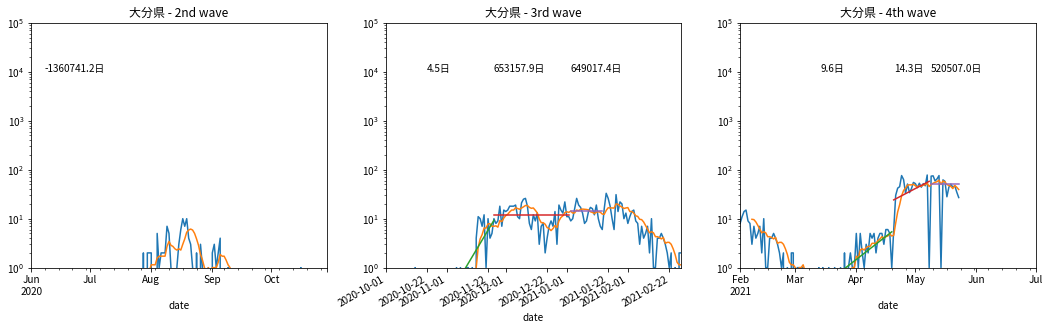

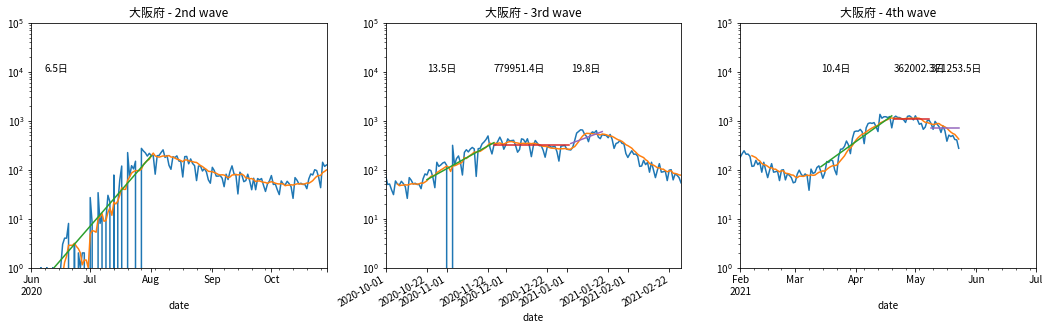

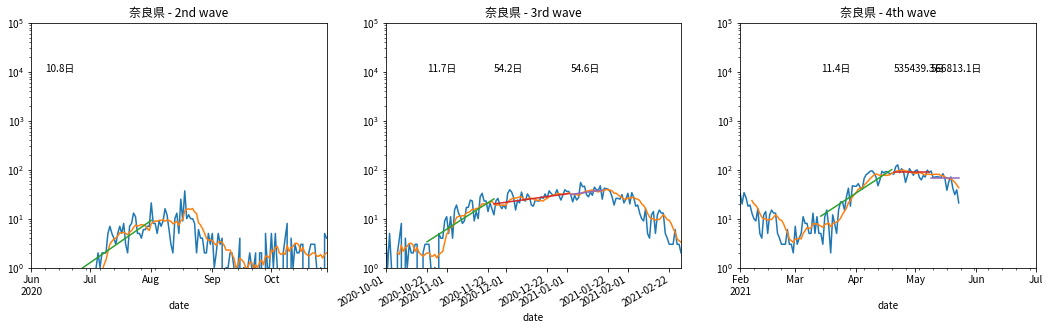

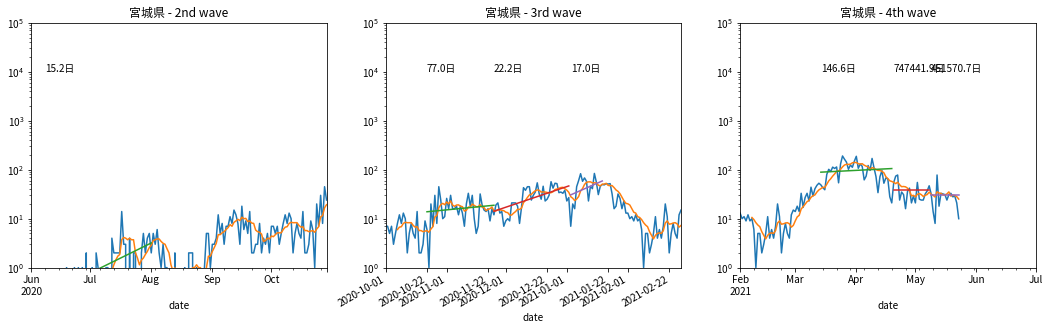

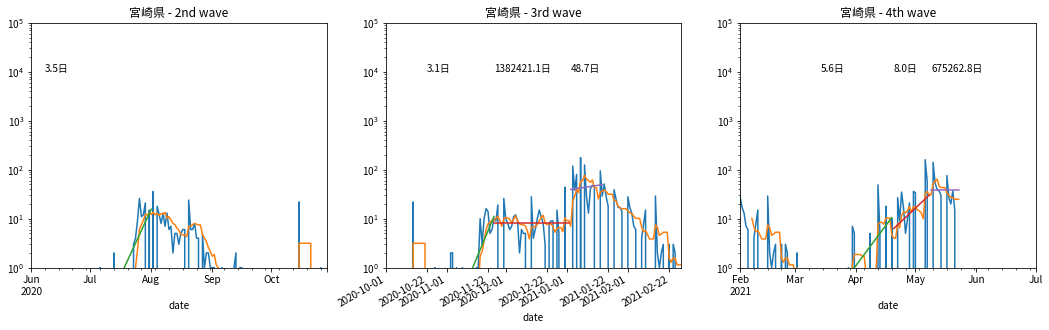

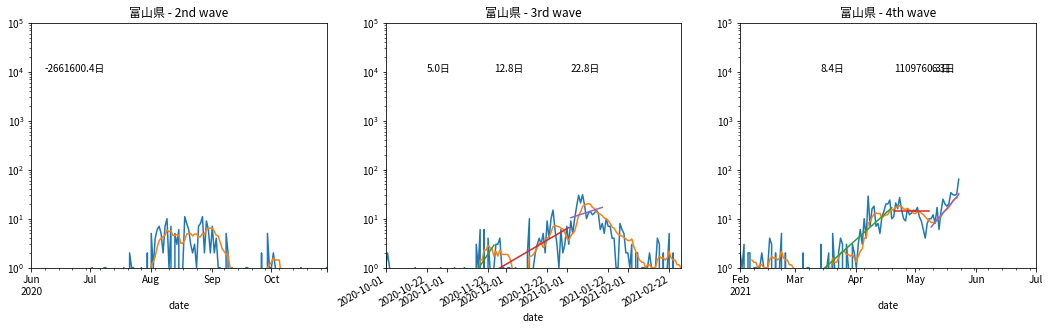

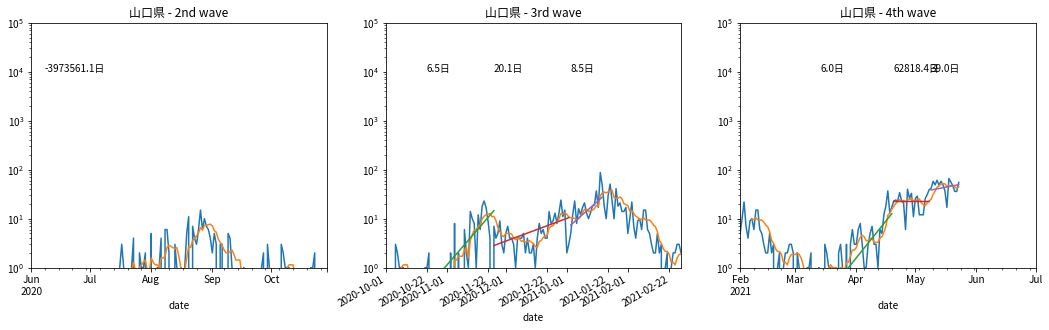

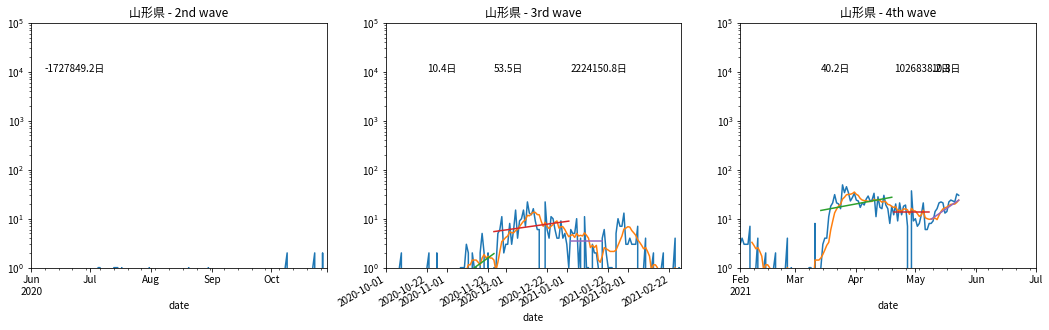

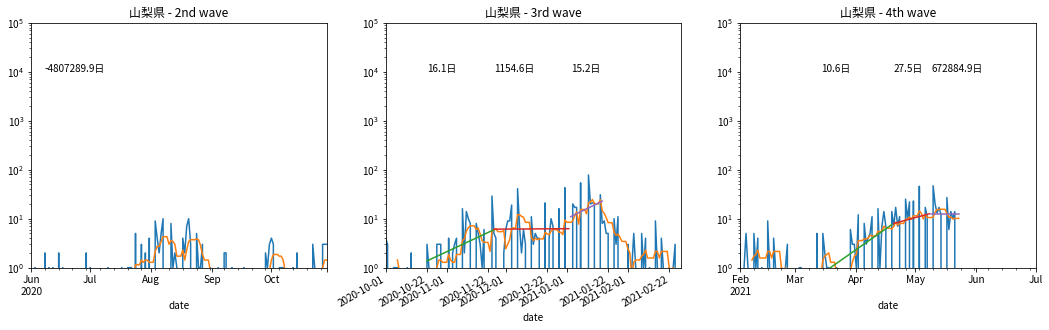

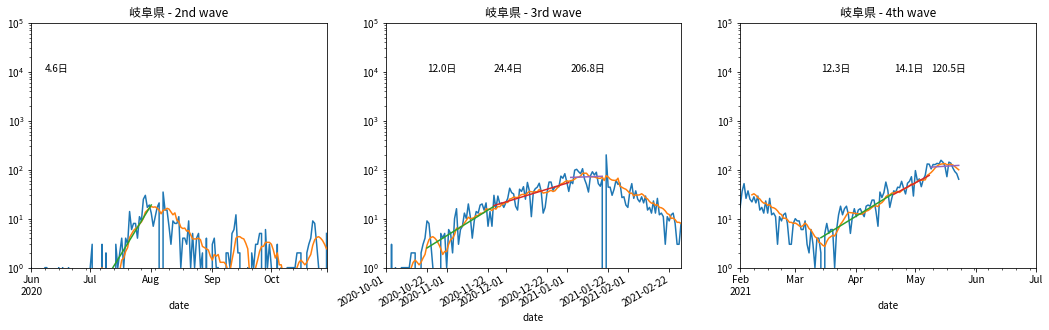

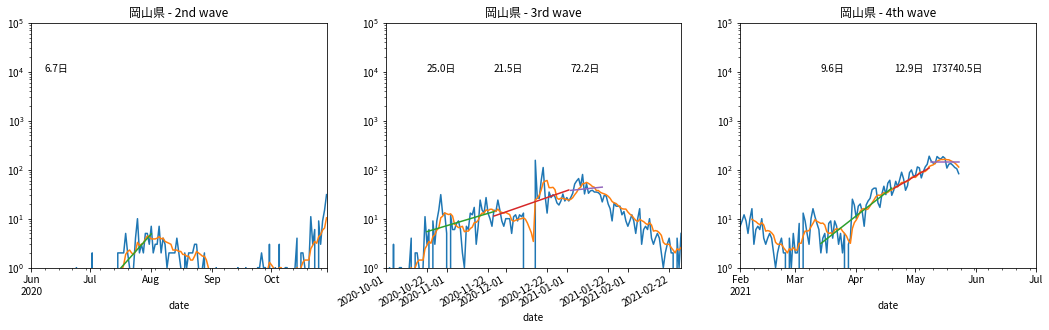

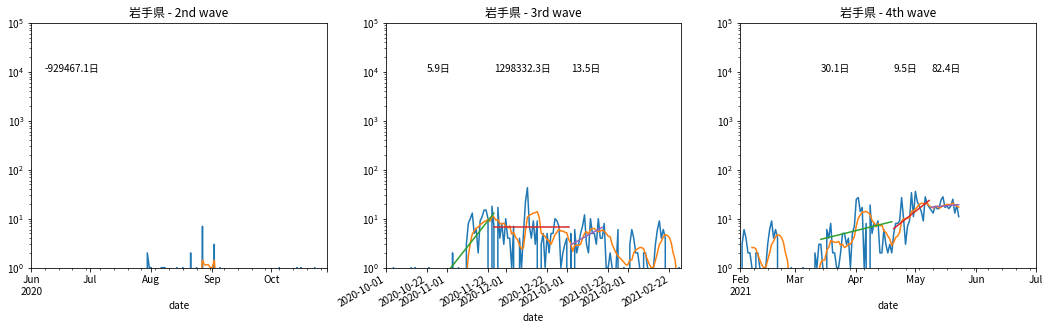

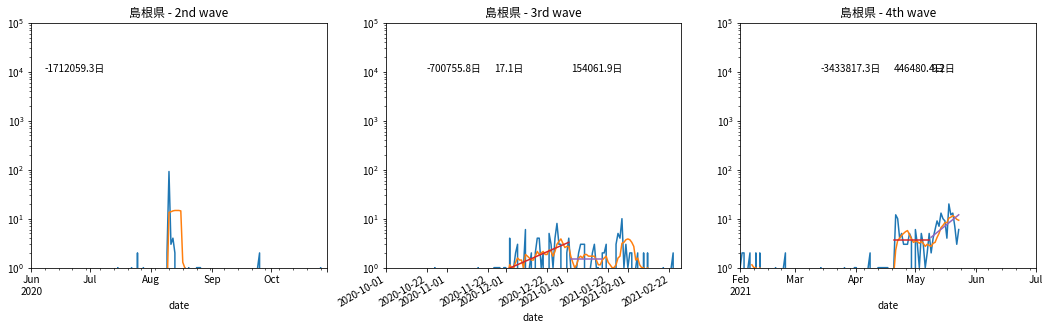

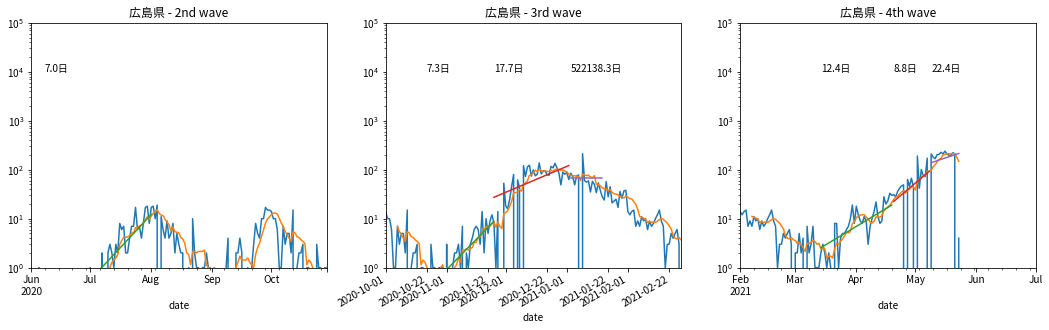

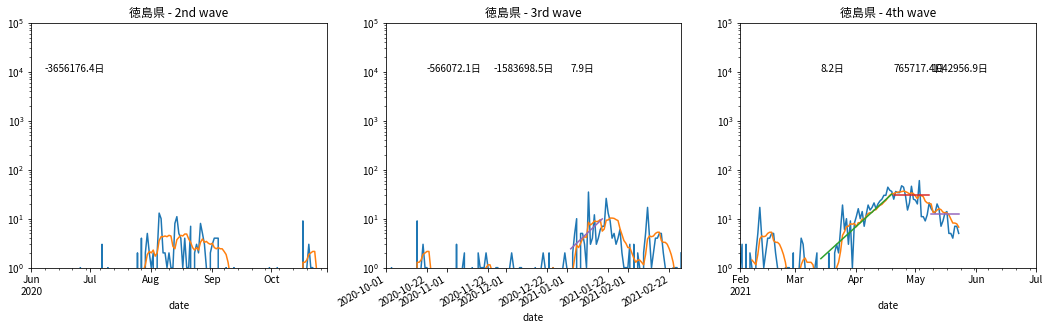

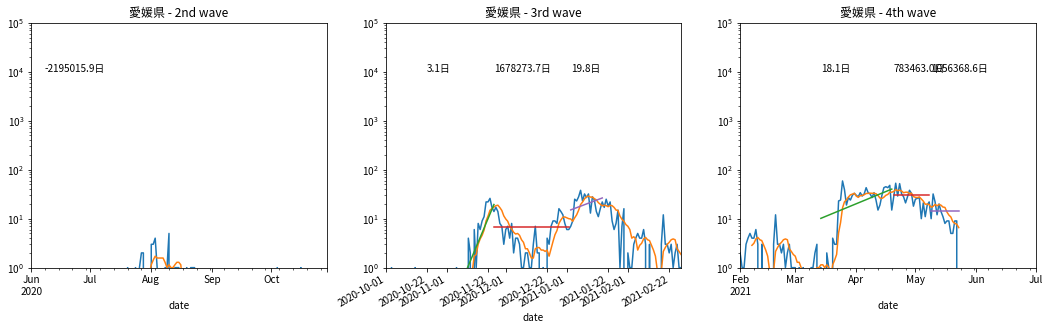

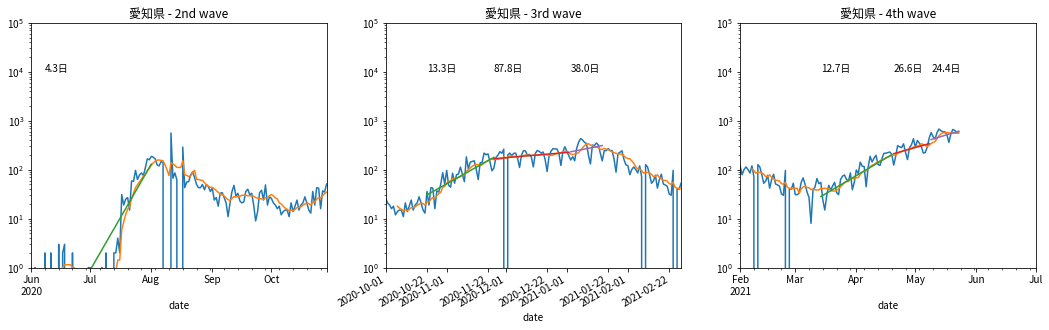

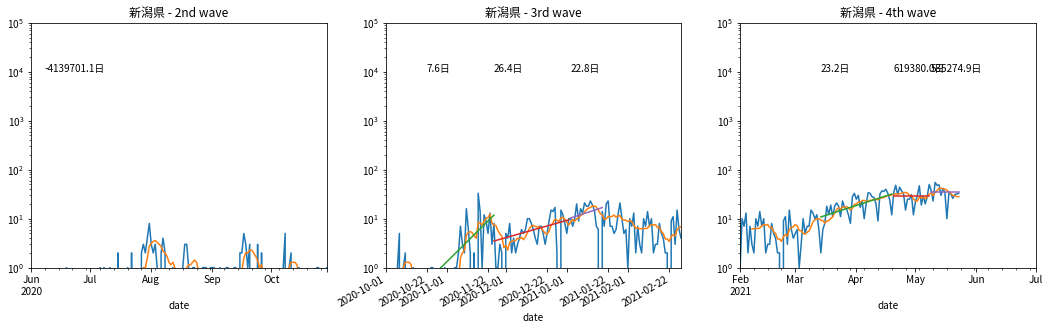

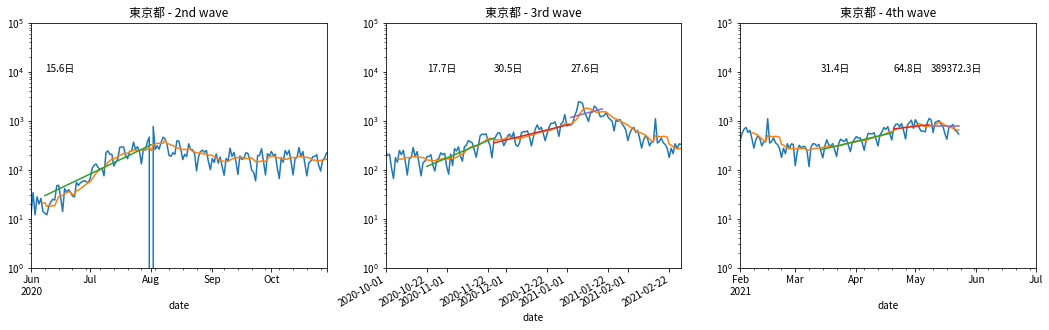

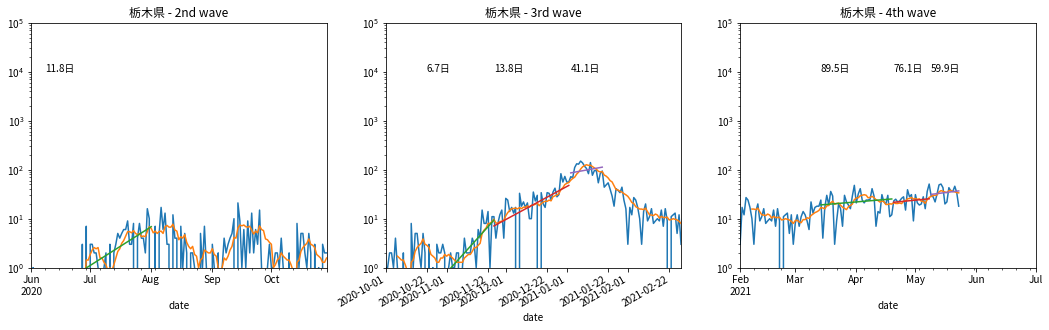

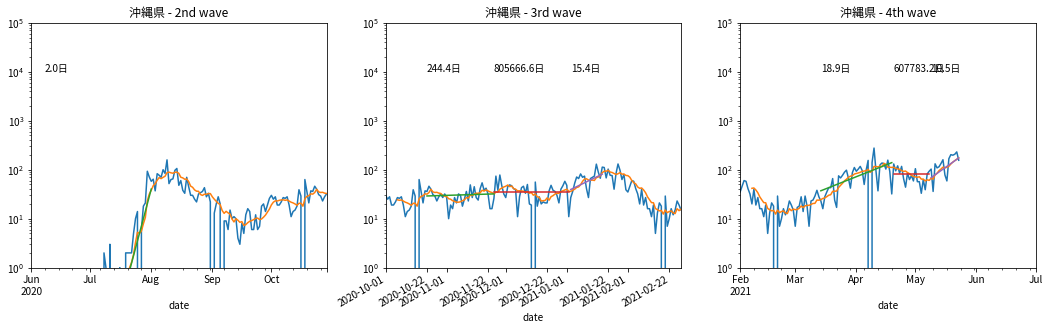

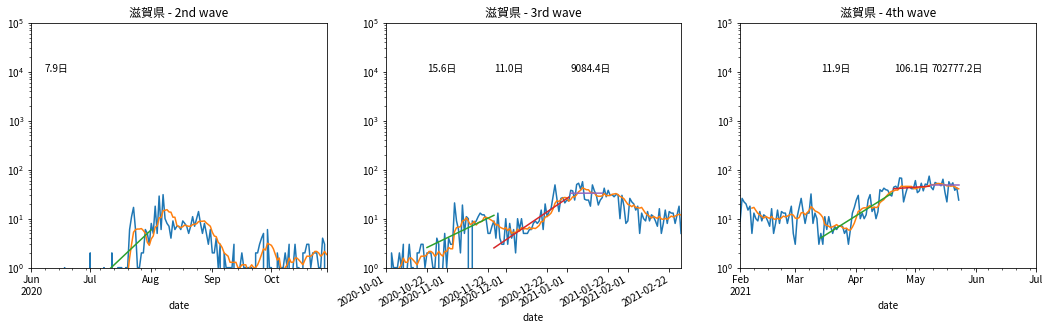

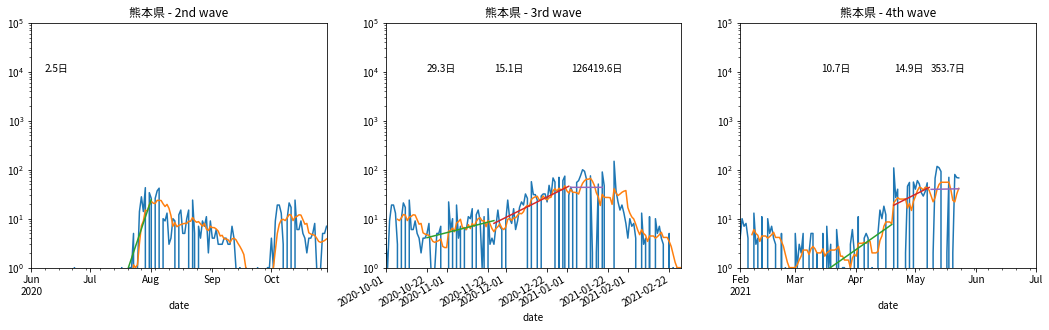

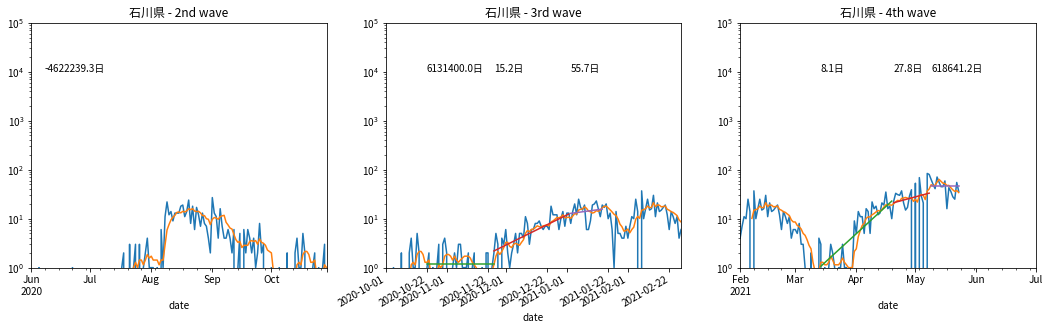

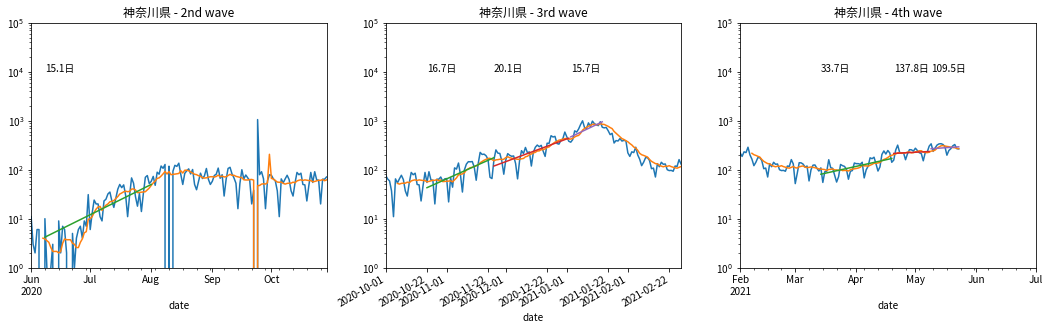

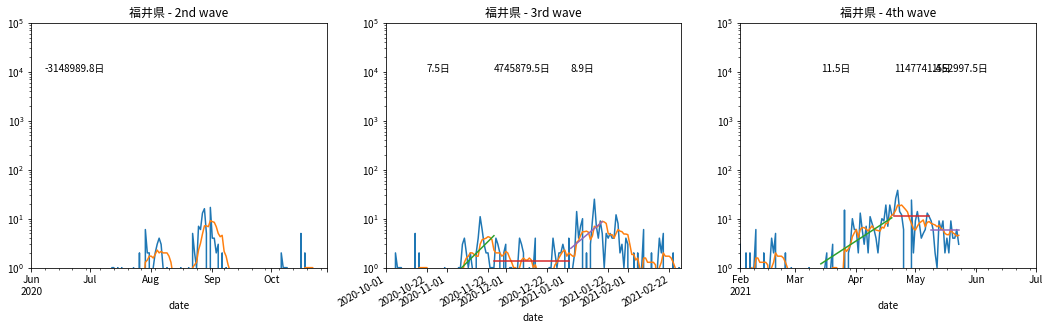

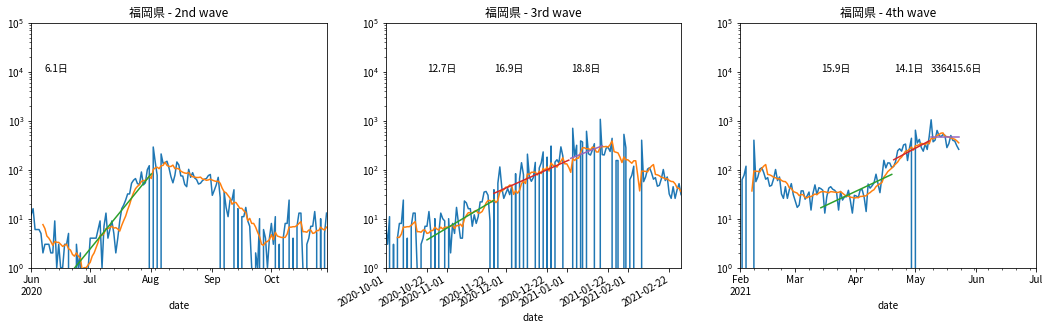

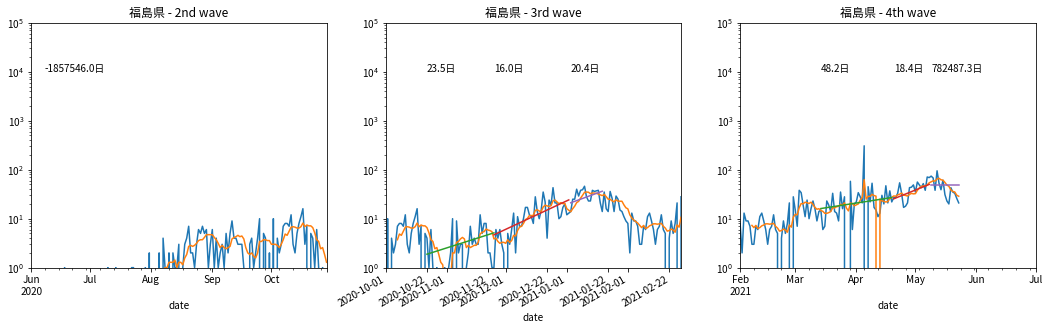

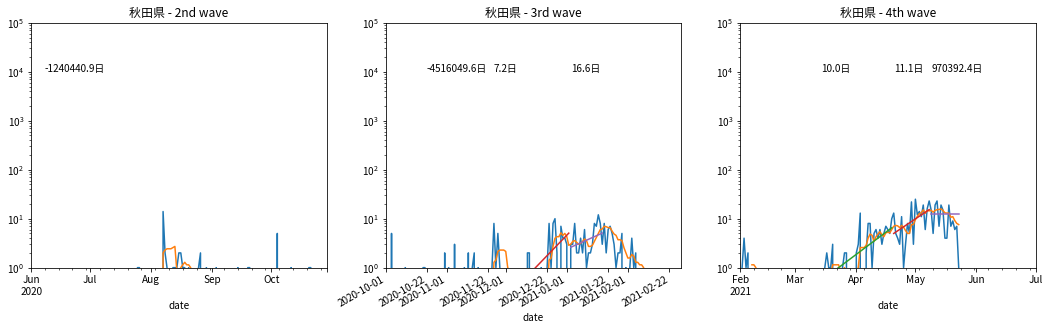

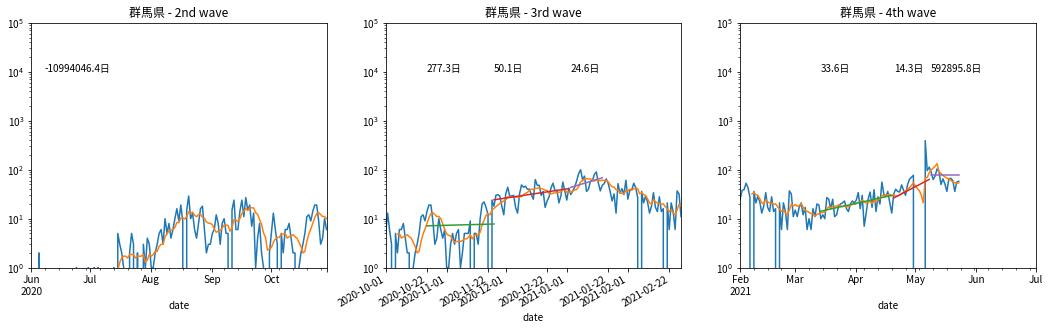

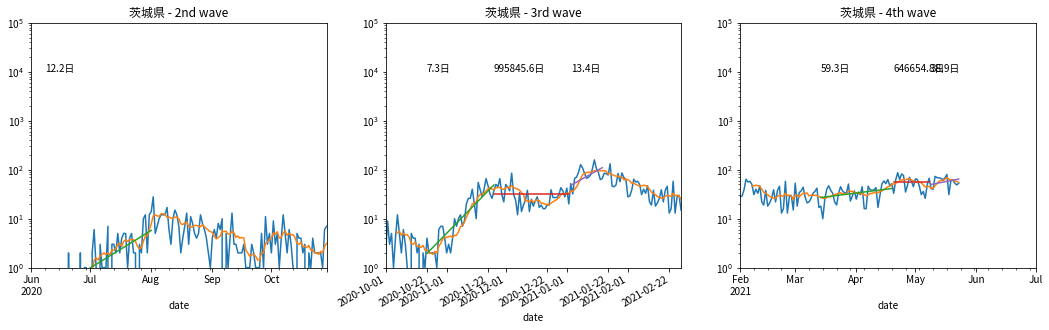

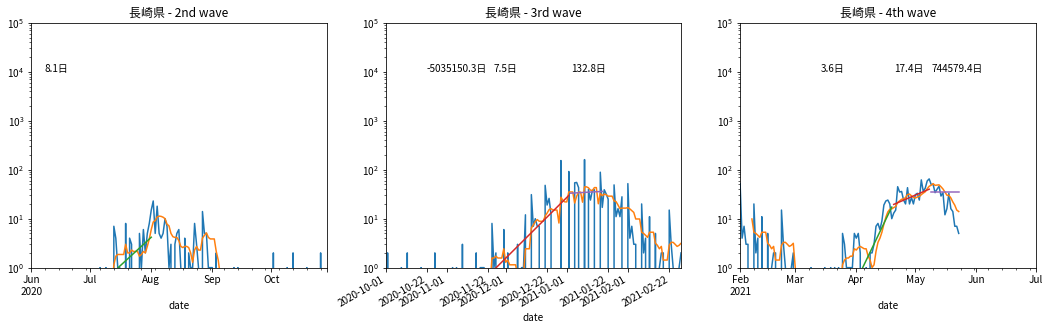

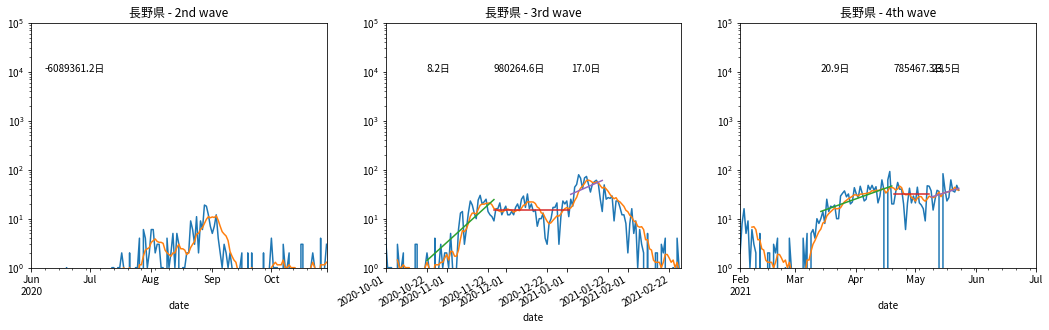

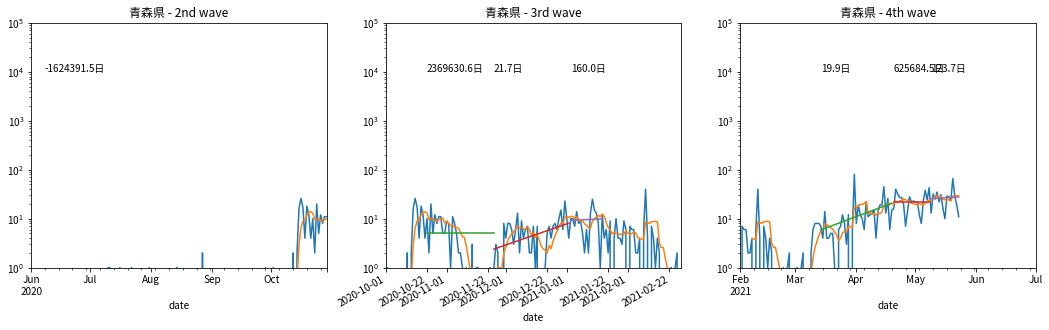

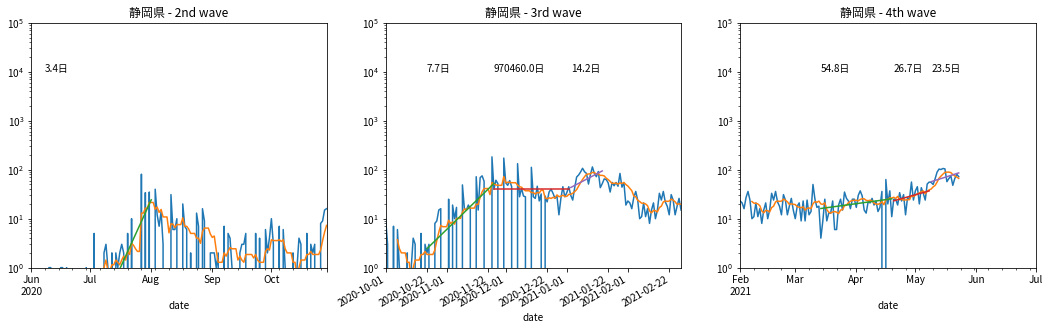

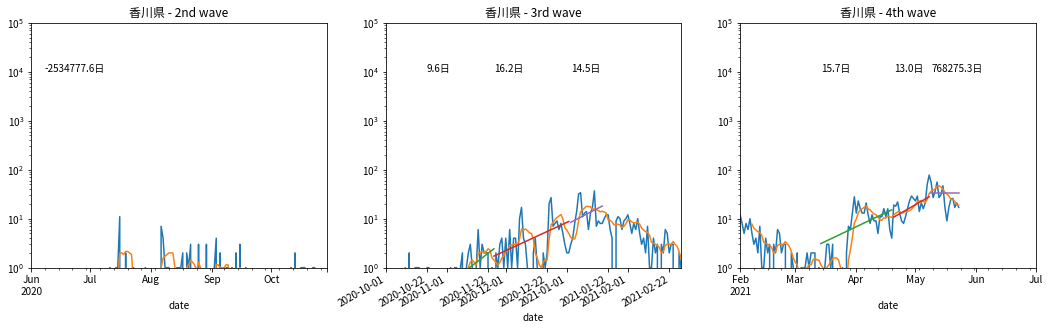

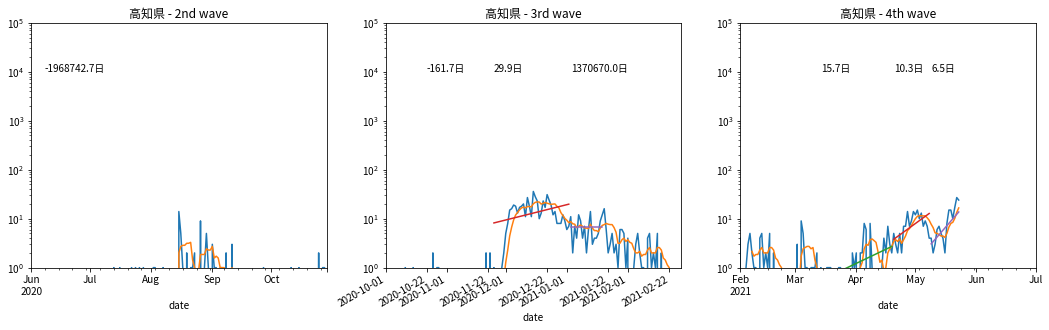

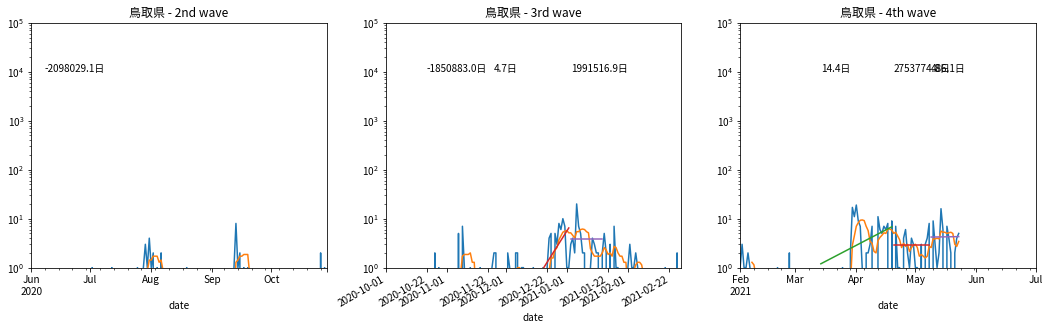

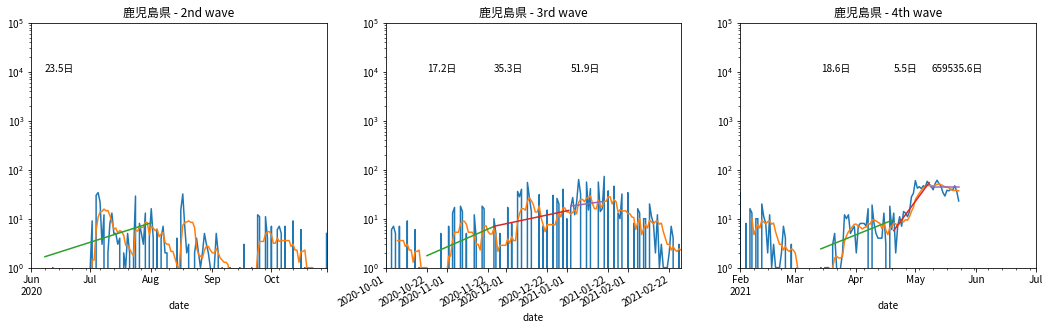

In [10]:
from scipy.optimize import curve_fit
import math

def power_func(x, a, c):
    return (a ** (x-c))

# フィッティング
def fit(df, col, FITTING_START, FITTING_END):
    training = df.loc[(df.index >= FITTING_START) & (df.index <= FITTING_END)].copy()
    training["x"] = (training.index - FITTING_START).map(lambda x: x.days)
#    display(training)
    params, cov = curve_fit(power_func, training["x"], training[col], maxfev=100000)
    return params

def num_ord(d):
    suffix = ["th", "st", "nd", "rd"]
    target = d % 10
    if target > 0 and target < 4:
        return "%d%s"%(target, suffix[target])
    else:
        return "%d%s"%(target, suffix[0])

!mkdir -p japan_trends/waves
DT = datetime.datetime
TD = datetime.timedelta

def estimate_doubling(target_pref):
    target_data = filtered[target_pref]

    periods = [
        [DT(2020,  1, 1), None, ], 
        [DT(2020,  6, 1), None, [DT(2020, 6, 8), DT(2020, 8, 1)]], 
        [DT(2020, 10, 1), None, [DT(2020, 10, 22), DT(2020, 11, 25)], [DT(2020, 11, 25), DT(2021, 1, 2)], [DT(2021, 1, 3), DT(2021, 1, 19)]],
        [DT(2021,  2, 1), None, [DT(2021, 3, 14), DT(2021,4,19)],[DT(2021, 4, 20), DT(2021, 5, 8)],[DT(2021, 5, 9), DT.now()]], 
    ]
    fig, axs = plt.subplots(1, len([p for p in periods if len(p) > 2]), figsize=(18, 5))
    
    ax_index = 0

    for i, period in enumerate(periods):
        period[1] = period[0] + TD(days=150)
        target_period = target_data.loc[(target_data.index>=period[0]) & (target_data.index<=period[1])].copy()
        target_period["npatients(avg)"] = target_period["npatients"].rolling(7).mean()

        fitting_periods = period[2:]
        if len(fitting_periods) == 0:
            continue
        estimated_ys = []
        eval = None
        params_list = []
        ax = axs[ax_index]
        ax_index += 1
        for j, fp in enumerate(fitting_periods):
            params = fit(target_period, "npatients(avg)", fp[0], fp[1])
            params_list.append(params)
            e = target_period.loc[(target_period.index>=fp[0])&(target_period.index<=fp[1])].copy()
            e["x"] = (e.index - fp[0]).map(lambda x: x.days)
            new_y = "estimation(%d-%d)"%(i,j)
            e[new_y] = e["x"].map(lambda x: power_func(x, *params))
            estimated_ys.append(new_y)
            if not eval is None:
                eval = pd.concat([eval, e], sort=True)
            else:
                eval = e
        eval = eval[["x"] + estimated_ys]
        target_period = target_period.join(eval, how="outer")

        ord_text = num_ord(i+1)
        target_period.plot(ax=ax, kind="line", logy=True, y = ["npatients", "npatients(avg)"] + estimated_ys, 
                           ylim =(10**0,10**5), xlim=(period[0], period[1]), 
                           figsize=(18, 5), legend=False, title = "%s - %s wave"%(target_pref, ord_text))
        for j, fp in enumerate(fitting_periods):
            params = params_list[j]
            doubling = math.log(2) / math.log(params[0])
            ax.annotate("%2.1f日"%(doubling,), xy=(fp[0], 10**4), color="black", fontweight = "normal")

    display(fig)
    plt.savefig("japan_trends/waves/%s-positive-logscale-%s.png"%(target_pref, ord_text), facecolor="white")
    plt.close()

for i in filtered.keys():
    estimate_doubling(i)

In [11]:
def to_per_million(pref, df):
    population = latest_populations.loc[pref].values[0]
    df["npatients"] = df["npatients"] / population * 10**6
    return df.rename(columns={"npatients": "new_cases_per_million"})

per_mill = {k:to_per_million(k, v.copy()) for k,v in filtered.items()}

In [12]:
new_cases_label = "new_cases_per_million"
freq = 7

def calc_monthly(df):
    df2=df.reset_index()
#    result = df2.groupby([df2["date"].dt.year, df2["date"].dt.month]).mean()
    result = df2.groupby(pd.Grouper(key="date", freq="%dd"%freq, base=df2.shape[0] % freq )).mean()
    return result

trends = per_mill

def calc_trend_map(region, df):
    monthly = calc_monthly(df)
    return (region, 
     monthly[new_cases_label].values[-1])

trend_map = pd.DataFrame([calc_trend_map(region, df) for region, df in trends.items()],
                        columns=["prefecture", new_cases_label]).set_index("prefecture")

def calc_trends(df):
    monthly = calc_monthly(df)
    diff = monthly.diff()
    return (diff/monthly).fillna(0)

recents = pd.DataFrame([[p] + list(calc_trends(df).iloc[-1]) for p, df in trends.items()], columns=["prefecture", "trend_new_cases"])
status = pd.merge(trend_map, recents, on="prefecture")
status.set_index("prefecture", inplace=True)

<ipython-input-12-d01118ef2640>:7: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  result = df2.groupby(pd.Grouper(key="date", freq="%dd"%freq, base=df2.shape[0] % freq )).mean()


In [13]:
per_mill["大阪府"]

new_cases_per_million
date                             
2020-04-22               0.000000
2020-04-23               4.058912
2020-04-24               3.595037
2020-04-25               3.363099
2020-04-26               1.855503
...                           ...
2021-05-19              55.201206
2021-05-20              58.100429
2021-05-21              48.127102
2021-05-22              47.083382
2021-05-23              31.775484

[397 rows x 1 columns]

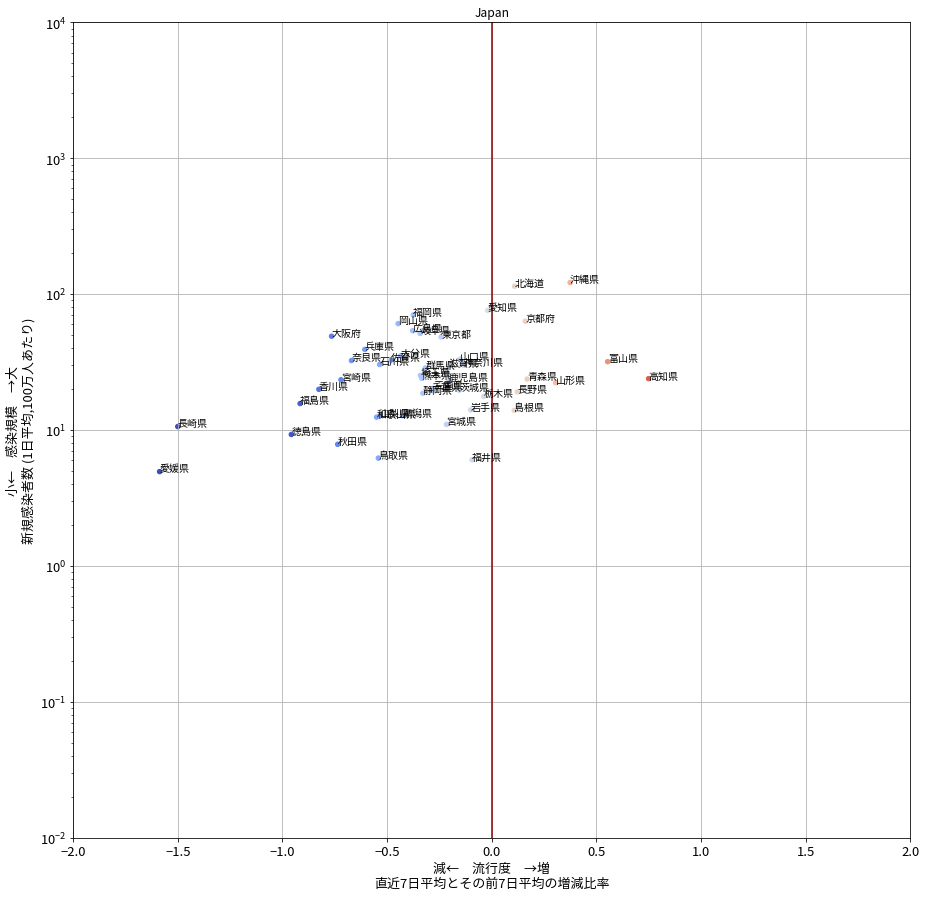

In [14]:
ymin=10**-2
ymax=10**4
xmin=-2
xmax=2

fig,ax=plt.subplots(figsize=(8, 8))

ax = ax
status.plot(ax=ax, kind="scatter", grid=True, 
        x="trend_new_cases", xlim=(xmin,xmax), 
        y=new_cases_label, logy=True, ylim=(ymin, ymax), 
        title="Japan",
        fontsize=13,
        legend=False,
        colorbar=False,
        c="trend_new_cases", colormap="coolwarm", vmin=-1, vmax=1, 
        figsize=(15,15))
ax.set_ylabel("小←　感染規模　→大\n新規感染者数 (1日平均,100万人あたり)", fontsize=13)
ax.set_xlabel("減←　流行度　→増\n直近{freq}日平均とその前{freq}日平均の増減比率".format(freq=freq), fontsize=13)
ax.vlines(0, ymin, ymax, linestyles="solid", color="darkred")
for i,r in status.iterrows():
    x = r["trend_new_cases"]
    y = r[new_cases_label]
    region = r.name
    if xmin <= x and x < xmax and ymin <= y and y < ymax:
        color = "black"
        fontweight = "normal"
        ax.annotate(region, xy=(x, y), color=color, fontweight = fontweight)
        
display(fig)
plt.savefig("japan_trends/trend-japan.png", facecolor="white")
plt.close()

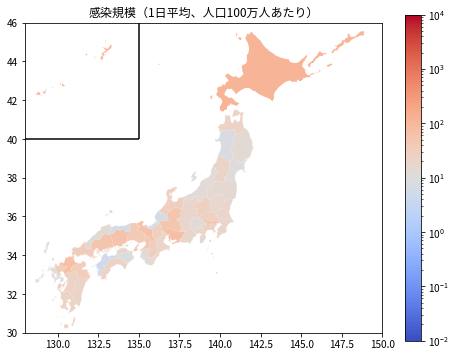

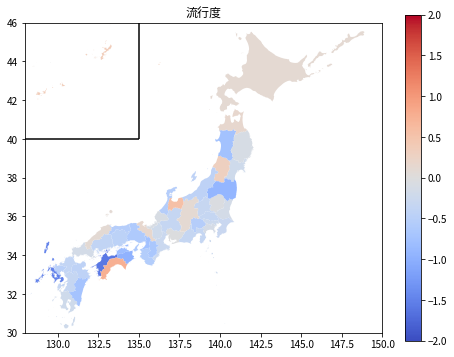

In [15]:
cmap=plt.get_cmap("coolwarm")

japan = gpd.read_file("data/land/japan.geojson")
japan2 = japan.copy()
japan2.loc[japan2["nam_ja"]=="沖縄県", "geometry"] = japan2.loc[japan2["nam_ja"]=="沖縄県"].geometry.translate(xoff=5, yoff=18)
per_mill_map = pd.merge(japan2, status, left_on="nam_ja", right_on="prefecture", how="inner")

def plot_japan(**kwargs):
    fig,ax=plt.subplots(figsize=(8,6))
    per_mill_map.plot(ax=ax, **kwargs)
    plt.ylim(30, 46)
    plt.xlim(128, 150)
    plt.hlines(40, 125, 135, color="black", linestyles="solid")
    plt.vlines(135, 40, 48, color="black", linestyles="solid")
    return fig, ax
    
fig, ax= plot_japan(column=new_cases_label, legend=True, 
                  cmap="coolwarm", norm=matplotlib.colors.LogNorm(vmin=ymin, vmax=ymax))
ax.set_title("感染規模（1日平均、人口100万人あたり）")
display(fig)
plt.savefig("japan_trends/per_mill-jpn-heatmap.png", facecolor="white")
plt.close()

fig, ax= plot_japan(column="trend_new_cases", legend=True, cmap="coolwarm", 
                    norm=matplotlib.colors.Normalize(vmin=xmin, vmax=xmax))
ax.set_title("流行度")
display(fig)
plt.savefig("japan_trends/trend-jpn-heatmap.png", facecolor="white")
plt.close()


<AxesSubplot:xlabel='date'>

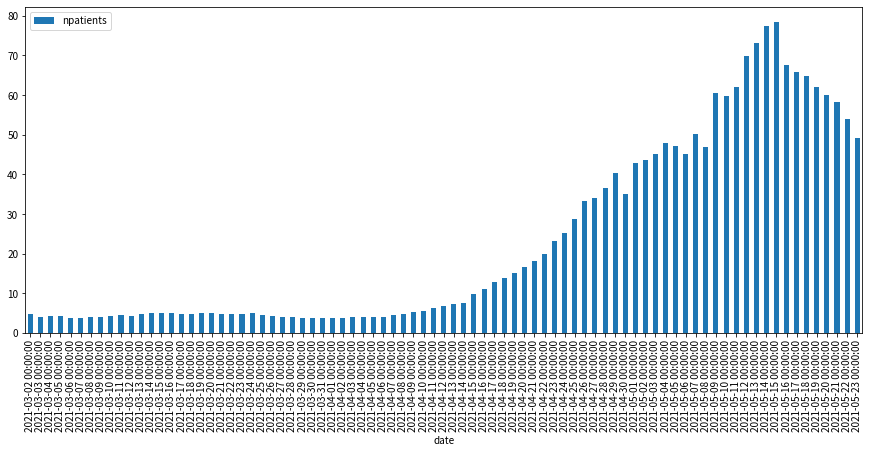

In [16]:
DT = datetime.datetime
TD = datetime.timedelta
target_pref="福岡県"
(filtered[target_pref].rolling(7).sum()/latest_populations.loc[latest_populations.index==target_pref].values[0]*10**5).loc[filtered[target_pref].index > DT(2021, 3, 1)].plot(kind="bar",figsize=(15,6))